# Setting Workspace

In [1]:
!pip install ipython-autotime
!pip install transformers

     |████████████████████████████████| 2.6 MB 13.7 MB/s 
     |████████████████████████████████| 636 kB 39.8 MB/s 
     |████████████████████████████████| 895 kB 50.1 MB/s 
     |████████████████████████████████| 3.3 MB 41.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
%load_ext autotime

time: 149 µs (started: 2021-08-16 11:07:58 +00:00)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 19.2 s (started: 2021-08-16 11:07:58 +00:00)


In [4]:
import os
os.chdir('/content/drive/My Drive/HLT/')
!pwd

/content/drive/My Drive/HLT
time: 134 ms (started: 2021-08-16 11:08:18 +00:00)


# Import Libraries

In [5]:
import json
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.regularizers import L2
from tensorflow.keras.losses import MSE
from tensorflow.keras.layers import Dropout
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Embedding, Concatenate, TimeDistributed, Bidirectional, GRU
from tensorflow.keras.layers import LSTM, Dense,Flatten,Conv2D,Conv1D,GlobalMaxPooling1D,GlobalMaxPool1D, GlobalAveragePooling1D, MaxPooling1D
from sklearn.metrics import classification_report,roc_auc_score,roc_curve,r2_score,recall_score,confusion_matrix,precision_recall_curve, precision_score, f1_score
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import GRU
# from tensorflow.keras.layers import CuDNNGRU
from sklearn.metrics import accuracy_score, confusion_matrix
import pydot_ng as pydot

time: 3.58 s (started: 2021-08-16 11:08:18 +00:00)


In [6]:
pd.set_option('display.max_colwidth', -1) #show all text in col
pd.set_option('display.max_rows', None) #show all rows

time: 7.41 ms (started: 2021-08-16 11:08:21 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


# Support Functions


In [7]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

time: 83.8 ms (started: 2021-08-16 11:08:21 +00:00)


# Load the Dataset

In [8]:
train_df = pd.read_csv("datasets/train.csv") 
train_df['headline']=train_df['headline'].apply(str)
train_df.head()

,headline,is_sarcastic
0,bill de blasio thinks proved haters wrong comes pre k,0
1,baby realize white supremacist yet,1
2,spring sprung arctic way early,0
3,mayor daley son appointed head illinois nepotist party,1
4,poll grandsons talented,1


time: 1.17 s (started: 2021-08-16 11:08:21 +00:00)


In [9]:
test_df = pd.read_csv("datasets/test.csv") 
test_df['headline']=test_df['headline'].apply(str)
test_df.head()

,headline,is_sarcastic
0,jessie james decker shares inspiring message post baby bodies,0
1,frustrated russian officials struggling get policies dysfunctional trump administration,1
2,second saturday staten island art walk,0
3,chris christie emits loud sob paul ryan asks crowd whether worse years ago,1
4,chicago police department monitor interactions public using new bullet cams,1


time: 561 ms (started: 2021-08-16 11:08:23 +00:00)


In [10]:
print("Train size:{}".format(train_df.shape))
print("Test size:{}".format(test_df.shape))

Train size:(22702, 2)
Test size:(4007, 2)
time: 1.57 ms (started: 2021-08-16 11:08:23 +00:00)


## Splitting the set



In [11]:
train_y = train_df['is_sarcastic']
test_y = test_df['is_sarcastic']

train_x = train_df['headline']
test_x = test_df['headline']
train_x.shape,train_y.shape,test_x.shape,test_y.shape

((22702,), (22702,), (4007,), (4007,))

time: 9.85 ms (started: 2021-08-16 11:08:23 +00:00)


# Glove


In [12]:
txt_best_grids = "grid_results/bidirectional_lstm/best_results_lstm_glove_v1.txt" # name of the txt file with all best results of all runned grid searches
grid_results_name = 'grid_results/bidirectional_lstm/grid_results_lstm_glove_v1.csv' # name of the csv file with all tests of the current grid search

time: 1.11 ms (started: 2021-08-16 11:08:23 +00:00)


In [13]:
##Build Static Embedding on top of a Neural Model

maxlen=26
max_features=200 
embed_size=300
 

#Tokenizing steps- must be remembered
tokenizer=Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_x))

train_x=tokenizer.texts_to_sequences(train_x)
test_x=tokenizer.texts_to_sequences(test_x)

#Pad the sequence- To allow same length for all vectorized words
train_x=pad_sequences(train_x,maxlen=maxlen)
test_x=pad_sequences(test_x,maxlen=maxlen)



EMBEDDING_FILE = 'Embeddings/glove.6B.200d.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding="utf8") if len(o)>100)

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


time: 28.5 s (started: 2021-08-16 11:08:23 +00:00)


#Final Models

## Bi-LSTM GLOVE

In [14]:
# Best: 0.6732005874315897 using {'activation': 'relu', 'batch_size': 256, 'dropout_1': 0.5, 'dropout_2': 0.1, 'epochs': 20, 'learn_rate': 0.001, 'neurons_layer_1': 256, 'neurons_layer_2': 128, 'neurons_layer_3': 64} 

time: 2.02 ms (started: 2021-08-16 11:08:52 +00:00)


In [15]:
inp=Input(shape=(maxlen,))
z=Embedding(max_features,embed_size,weights=[embedding_matrix])(inp)
z=Bidirectional(LSTM(256,return_sequences='True'))(z)
z=GlobalMaxPool1D()(z)
z=Dense(128,activation='relu')(z)
z=Dropout(0.5)(z)
z=Dense(64,activation='relu')(z)
z=Dropout(0.1)(z)
z=Dense(1,activation='sigmoid')(z)
model=Model(inputs=inp,outputs=z)
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()
plot_model(
    model,
    to_file="model_img/lstm_glove.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

history = model.fit(train_x,train_y,batch_size=256,epochs=20,verbose=2)#, validation_split=0.1)#validation_data=(val_x,val_y))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 26)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 26, 200)           40000     
_________________________________________________________________
bidirectional (Bidirectional (None, 26, 512)           935936    
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256  

### Evaluation with Validation

In [16]:
accr = model.evaluate(test_x,test_y)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

126/126 [==============================] - 2s 9ms/step - loss: 0.7326 - accuracy: 0.6748
Test set
  Loss: 0.733
  Accuracy: 0.675
time: 2.24 s (started: 2021-08-16 11:10:27 +00:00)


In [17]:
print("Validation Loss and Accuracy: ")
loss, accuracy = model.evaluate(test_x, test_y, verbose = 1)

Validation Loss and Accuracy: 
126/126 [==============================] - 1s 10ms/step - loss: 0.7326 - accuracy: 0.6748
time: 1.31 s (started: 2021-08-16 11:10:30 +00:00)


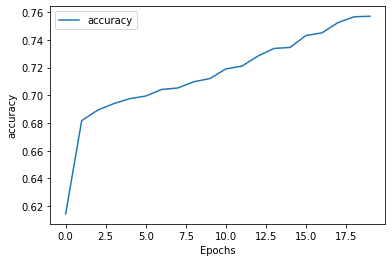

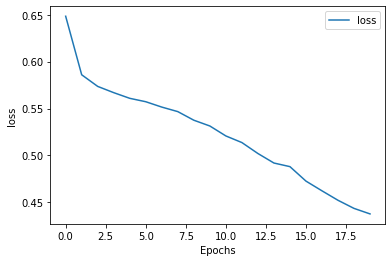

time: 507 ms (started: 2021-08-16 11:10:31 +00:00)


In [18]:
#Plot
def plot_graphs(history, string):
    plt.plot(history.history[string])
    #plt.plot(history.history["val_"+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string,"val_"+string])
    plt.show()
plot_graphs(history,'accuracy')
plot_graphs(history,'loss')

In [19]:
# #Save the model 
# model.save_weights("model.h5")

time: 1.17 ms (started: 2021-08-16 11:10:31 +00:00)


### Evaluation without Validation

In [20]:
accr = model.evaluate(test_x,test_y)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

126/126 [==============================] - 1s 10ms/step - loss: 0.7326 - accuracy: 0.6748
Test set
  Loss: 0.733
  Accuracy: 0.675
time: 1.32 s (started: 2021-08-16 11:10:31 +00:00)


In [21]:
print("Validation Loss and Accuracy: ")
loss, accuracy = model.evaluate(test_x, test_y, verbose = 1)

Validation Loss and Accuracy: 
126/126 [==============================] - 1s 11ms/step - loss: 0.7326 - accuracy: 0.6748
time: 1.42 s (started: 2021-08-16 11:10:33 +00:00)


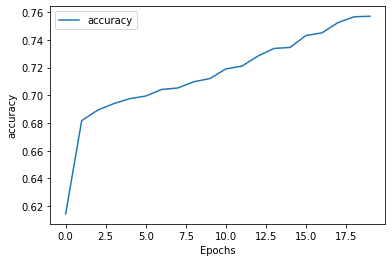

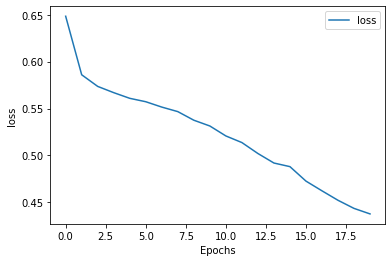

time: 441 ms (started: 2021-08-16 11:10:34 +00:00)


In [22]:
#Plot
def plot_graphs(history, string):
    plt.plot(history.history[string])
    #plt.plot(history.history["val_"+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string,"val_"+string])
    plt.show()
plot_graphs(history,'accuracy')
plot_graphs(history,'loss')

In [23]:
# #Save the model 
# model.save_weights("model.h5")

time: 1.08 ms (started: 2021-08-16 11:10:35 +00:00)


## Bi-LSTM Embeddings

In [24]:
# Best: 0.6755792697270712 using {'activation': 'relu', 'batch_size': 256, 'dropout_1': 0.5, 'dropout_2': 0.1, 'epochs': 20, 'learn_rate': 0.001, 'neurons_layer_1': 256, 'neurons_layer_2': 128, 'neurons_layer_3': 64} 

time: 1.7 ms (started: 2021-08-16 11:10:35 +00:00)


In [25]:
inp=Input(shape=(maxlen,))
z=Embedding(max_features,embed_size)(inp)
z=Bidirectional(LSTM(256,return_sequences='True'))(z)
z=GlobalMaxPool1D()(z)
z=Dense(128,activation='relu')(z)
z=Dropout(0.5)(z)
z=Dense(64,activation='relu')(z)
z=Dropout(0.1)(z)
z=Dense(1,activation='sigmoid')(z)
model=Model(inputs=inp,outputs=z)
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()
plot_model(
    model,
    to_file="model_img/lstm_embeddings.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

history = model.fit(train_x,train_y,batch_size=256,epochs=20,verbose=2)#, validation_split=0.1)#validation_data=(val_x,val_y))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 26)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 26, 200)           40000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 26, 512)           935936    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256

### Evaluation without Validation

In [26]:
accr = model.evaluate(test_x,test_y)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

126/126 [==============================] - 2s 12ms/step - loss: 0.6002 - accuracy: 0.6806
Test set
  Loss: 0.600
  Accuracy: 0.681
time: 2.38 s (started: 2021-08-16 11:12:02 +00:00)


In [27]:
print("Validation Loss and Accuracy: ")
loss, accuracy = model.evaluate(test_x, test_y, verbose = 1)

Validation Loss and Accuracy: 
126/126 [==============================] - 1s 12ms/step - loss: 0.6002 - accuracy: 0.6806
time: 1.54 s (started: 2021-08-16 11:12:04 +00:00)


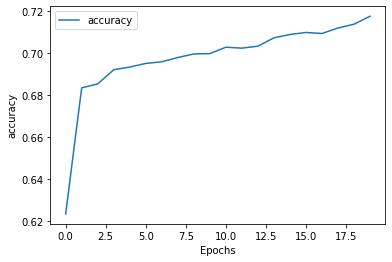

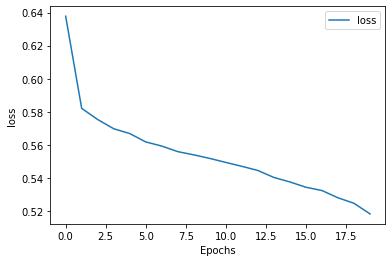

time: 774 ms (started: 2021-08-16 11:12:06 +00:00)


In [28]:
#Plot
def plot_graphs(history, string):
    plt.plot(history.history[string])
    #plt.plot(history.history["val_"+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string,"val_"+string])
    plt.show()
plot_graphs(history,'accuracy')
plot_graphs(history,'loss')

In [29]:
# #Save the model 
# model.save_weights("model.h5")

time: 5.32 ms (started: 2021-08-16 11:12:07 +00:00)


## CNN Glove

In [30]:
# Best: 0.6808650294939677 using {'activation': 'relu', 'batch_size': 256, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.1, 'epochs': 20, 'kernel_size': 3, 'learn_rate': 0.0001, 'neurons_layer_1': 256, 'neurons_layer_2': 128, 'neurons_layer_3': 64, 'neurons_layer_4': 32} 

time: 2.76 ms (started: 2021-08-16 11:12:07 +00:00)


In [31]:
inp=Input(shape=(maxlen,))
z=Embedding(max_features,embed_size,weights=[embedding_matrix])(inp)
z=Conv1D(256,activation='relu', kernel_size= 3)(z)
z=GlobalMaxPool1D()(z)
z=Dense(128,activation='relu')(z)
z=Dropout(0.5)(z)
z=Dense(64,activation='relu')(z)
z=Dropout(0.5)(z)
z=Dense(32,activation='relu')(z)
z=Dropout(0.1)(z)
z=Dense(1,activation='sigmoid')(z)
model=Model(inputs=inp,outputs=z)
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()
plot_model(
    model,
    to_file="model_img/cnn_glove.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

history = model.fit(train_x,train_y,batch_size=256,epochs=20,verbose=2)#, validation_split=0.1)#validation_data=(val_x,val_y))

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 26)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 26, 200)           40000     
_________________________________________________________________
conv1d (Conv1D)              (None, 24, 256)           153856    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256

### Evaluation without Validation

In [32]:
accr = model.evaluate(test_x,test_y)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

126/126 [==============================] - 1s 4ms/step - loss: 0.5665 - accuracy: 0.6955
Test set
  Loss: 0.566
  Accuracy: 0.696
time: 676 ms (started: 2021-08-16 11:12:57 +00:00)


In [33]:
print("Validation Loss and Accuracy: ")
loss, accuracy = model.evaluate(test_x, test_y, verbose = 1)

Validation Loss and Accuracy: 
126/126 [==============================] - 0s 3ms/step - loss: 0.5665 - accuracy: 0.6955
time: 695 ms (started: 2021-08-16 11:12:58 +00:00)


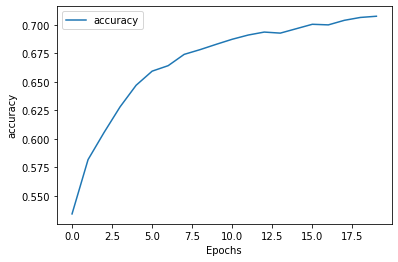

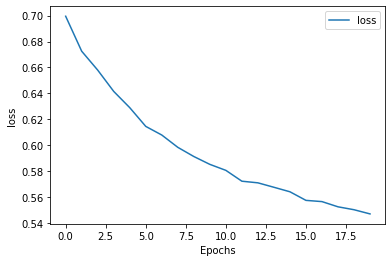

time: 453 ms (started: 2021-08-16 11:12:58 +00:00)


In [34]:
#Plot
def plot_graphs(history, string):
    plt.plot(history.history[string])
    #plt.plot(history.history["val_"+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string,"val_"+string])
    plt.show()
plot_graphs(history,'accuracy')
plot_graphs(history,'loss')

In [35]:
# #Save the model 
# model.save_weights("model.h5")

time: 1.41 ms (started: 2021-08-16 11:12:59 +00:00)


## CNN Embeddings

In [37]:
# Best: 0.6812615791956583 using {'activation': 'relu', 'batch_size': 256, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.3, 'epochs': 20, 'kernel_size': 3, 'learn_rate': 0.0001, 'neurons_layer_1': 256, 'neurons_layer_2': 128, 'neurons_layer_3': 64, 'neurons_layer_4': 32} 

time: 1.2 ms (started: 2021-08-16 11:14:25 +00:00)


In [38]:
inp=Input(shape=(maxlen,))
z=Embedding(max_features,embed_size)(inp)
z=Conv1D(256,activation='relu', kernel_size= 3)(z)
z=GlobalMaxPool1D()(z)
z=Dense(128,activation='relu')(z)
z=Dropout(0.5)(z)
z=Dense(64,activation='relu')(z)
z=Dropout(0.5)(z)
z=Dense(32,activation='relu')(z)
z=Dropout(0.3)(z)
z=Dense(1,activation='sigmoid')(z)
model=Model(inputs=inp,outputs=z)
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()
plot_model(
    model,
    to_file="model_img/cnn_embeddings.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

history = model.fit(train_x,train_y,batch_size=256,epochs=20,verbose=2)#, validation_split=0.1)#validation_data=(val_x,val_y))

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 26)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 26, 200)           40000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 24, 256)           153856    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256

### Evaluation without Validation

In [39]:
accr = model.evaluate(test_x,test_y)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

126/126 [==============================] - 1s 3ms/step - loss: 0.5677 - accuracy: 0.6885
Test set
  Loss: 0.568
  Accuracy: 0.689
time: 833 ms (started: 2021-08-16 11:14:52 +00:00)


In [40]:
print("Validation Loss and Accuracy: ")
loss, accuracy = model.evaluate(test_x, test_y, verbose = 1)

Validation Loss and Accuracy: 
126/126 [==============================] - 0s 3ms/step - loss: 0.5677 - accuracy: 0.6885
time: 499 ms (started: 2021-08-16 11:14:53 +00:00)


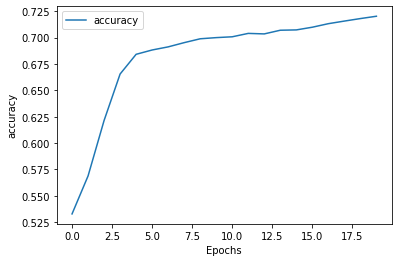

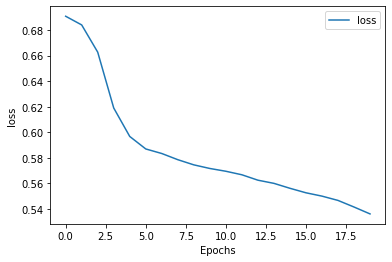

time: 489 ms (started: 2021-08-16 11:14:53 +00:00)


In [41]:
#Plot
def plot_graphs(history, string):
    plt.plot(history.history[string])
    #plt.plot(history.history["val_"+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string,"val_"+string])
    plt.show()
plot_graphs(history,'accuracy')
plot_graphs(history,'loss')

In [42]:
# #Save the model 
# model.save_weights("model.h5")

time: 1.22 ms (started: 2021-08-16 11:14:54 +00:00)
